In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm




In [2]:
df = pd.read_csv("lego.population.csv", sep=",", encoding="latin1")
# fjerner forklaringsvariabler vi ikke trenger


df2 = df[
    ["Set_Name", "Theme", "Klassifisering", "Price", "Pages", "Pieces", "Unique_Pieces"]
]

# fjerner observasjoner med manglende datapunkter
df2 = df2.dropna()

klassifisering_mapping = {"N": 0, "B": 1, "G": 2}
df2["Klassifisering_norm"] = df2["Klassifisering"].map(klassifisering_mapping)

# gjør themes om til string og fjern alle tegn vi ikke vil ha med
df2["Theme"] = df2["Theme"].astype(str)
df2["Theme"] = df2["Theme"].str.replace(r"[^a-zA-Z0-9\s-]", "", regex=True)

# fjerner dollartegn og trademark-tegn fra datasettet
df2["Price"] = df2["Price"].str.replace("\$", "", regex=True)

# og gjør så prisen om til float
df2["Price"] = df2["Price"].astype(float)

In [3]:
formel = 'Price ~ Klassifisering_norm'

modell = smf.ols(formel, data = df2)
resultat = modell.fit()

resultat.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     3.584
Date:                Thu, 02 Nov 2023   Prob (F-statistic):             0.0586
Time:                        10:54:42   Log-Likelihood:                -5049.4
No. Observations:                 922   AIC:                         1.010e+04
Df Residuals:                     920   BIC:                         1.011e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              52.3419      3.369     15.535      0.000      45.729      58.955
Klassifisering_norm    -5.5228      2.917     -1.893      0.059     -11.248       0.202
==============================================================================
Omnibus:                      841.318   Durbin-Watson:                   0.896
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            31109.052
Skew:                           4.120   Prob(JB):                         0.00
Kurtosis:                      30.237   Cond. No.                         3.26
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

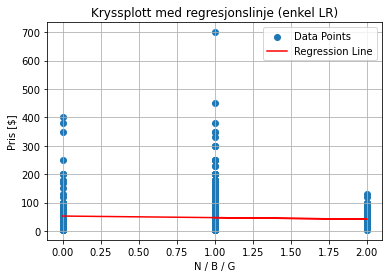

In [4]:
slope = resultat.params['Klassifisering_norm']
intercept = resultat.params['Intercept']

regression_x = np.array(df2['Klassifisering_norm'])

regression_y = slope * regression_x + intercept

plt.scatter(df2['Klassifisering_norm'], df2['Price'], label='Data Points')
plt.plot(regression_x, regression_y, color='red', label='Regression Line')
plt.xlabel('N / B / G')
plt.ylabel('Pris [$]')
plt.title('Kryssplott med regresjonslinje (enkel LR)')
plt.legend()
plt.grid()
plt.show()

In [6]:
print(len(df2['Klassifisering_norm']))
print(len(df2['Price']))
print(len(df2['Pieces']))

922
922
922


In [18]:
# multippel lineær regresjon
modell3_mlr = smf.ols('Price ~ Pieces + Klassifisering_norm' , data = df2)
results_mlr = modell3_mlr.fit()
summary_mlr = results_mlr.summary()


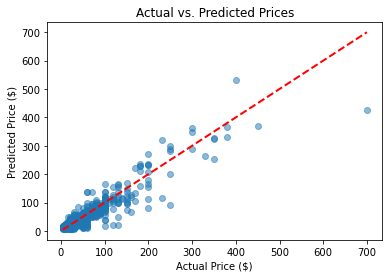

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     2732.
Date:                Thu, 02 Nov 2023   Prob (F-statistic):               0.00
Time:                        11:08:52   Log-Likelihood:                -4157.7
No. Observations:                 922   AIC:                             8321.
Df Residuals:                     919   BIC:                             8336.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               5.7689      1.429      4.037      0.000       2.965       8.573
Pieces                  0.0875      0.001     73.747      0.000       0.085       0.090
Klassifisering_norm     3.1235      1.116      2.799      0.005       0.934       5.314
==============================================================================
Omnibus:                      737.023   Durbin-Watson:                   1.246
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            44856.684
Skew:                           3.127   Prob(JB):                         0.00
Kurtosis:                      36.593   Cond. No.                     1.79e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.79e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [19]:
df2['Predicted_Price'] = results_mlr.predict(df2[['Pieces', 'Klassifisering_norm']])

plt.scatter(df2['Price'], df2['Predicted_Price'], alpha=0.5)
plt.plot([df2['Price'].min(), df2['Price'].max()], 
         [df2['Price'].min(), df2['Price'].max()], 
         '--', color='red', linewidth=2)
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
plt.title('Actual vs. Predicted Prices')
plt.show()

summary_mlr
